Импортируем numpy необходимой версии, чтобы не было конфликта

In [1]:
pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.2+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.4 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2

В работе используется tensorflow 1 версии

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


В блоках ниже устанавливаются необходимые библиотеки 

tf_slim используется как средство, позволяющее создавать модели более компактно

In [2]:
pip install --upgrade tf_slim

     |████████████████████████████████| 352 kB 4.8 MB/s 


In [3]:
pip install lvis

Клонируем репозиторий TensorFlow Models

In [4]:
!git clone --branch r1.13.0 --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2428/2428), done.
remote: Total 2927 (delta 503), reused 2114 (delta 424), pack-reused 0
Receiving objects: 100% (2927/2927), 369.04 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (2768/2768), done.


Устанавливаем protobuf и компилируем необходимые файлы в object_detection

In [5]:
!apt-get -qq install libprotobuf-java protobuf-compiler                                                
%cd ./models/research/
!protoc object_detection/protos/*.proto --python_out=.
%cd ../.. 

/content/models/research
/content


 Добавляем необходимые пути в переменную окружения PYTHONPATH

In [6]:
import os

os.environ['PYTHONPATH'] += ":/content/models/research/"
os.environ['PYTHONPATH'] += ":/content/models/research/slim"
os.environ['PYTHONPATH'] += ":/content/models/research/object_detection"
os.environ['PYTHONPATH'] += ":/content/models/research/object_detection/utils"

Далее идет раздел подключение к Google disk и загрузка training_demo.zip содержащего нашу модель и дата-сет, а также его распаковка

In [7]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [8]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
drive_file_id="1mf2Qxsnyk99OTwZFbQqc9SVUTzqUSP42"

training_demo_zip = drive.CreateFile({'id': '1mf2Qxsnyk99OTwZFbQqc9SVUTzqUSP42'})
training_demo_zip.GetContentFile('training_demo.zip')

!unzip training_demo.zip
!rm training_demo.zip

Archive:  training_demo.zip
   creating: training_demo/annotations/
  inflating: training_demo/annotations/label_map.pbtxt  
  inflating: training_demo/annotations/test.record  
  inflating: training_demo/annotations/test_labels.csv  
  inflating: training_demo/annotations/train.record  
  inflating: training_demo/annotations/train_labels.csv  
   creating: training_demo/images/
   creating: training_demo/images/test/
  inflating: training_demo/images/test/i (100).jpg  
  inflating: training_demo/images/test/i (100).xml  
  inflating: training_demo/images/test/i (101).jpg  
  inflating: training_demo/images/test/i (101).xml  
  inflating: training_demo/images/test/i (102).jpg  
  inflating: training_demo/images/test/i (102).xml  
  inflating: training_demo/images/test/i (103).jpg  
  inflating: training_demo/images/test/i (103).xml  
  inflating: training_demo/images/test/i (104).jpg  
  inflating: training_demo/images/test/i (104).xml  
  inflating: training_demo/images/test/i (105).j

Выполняем обучение модели

In [10]:
!python ./models/research/object_detection/legacy/train.py --logtostderr --train_dir=./training_demo/training --pipeline_config_path=./training_demo/training/ssdlite_mobilenet_v2_coco.config 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






Instructions for updating:
Use object_detection/model_main.py.
W0501 19:57:11.086491 140127110678400 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:258: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.

W0501 19:57:11.086691 140127110678400 module_wrapper.py:139] From ./models/research/object_detection/legacy/train.py:90: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0501 19:57:11.086937 140127110678400 module_wrapper.py:139] From /content/models/research/object_detec

Конвертируем результат обучения в frozen graph, который можно будет использовать

In [12]:
!python /content/models/research/object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path /content/training_demo/training/ssdlite_mobilenet_v2_coco.config --trained_checkpoint_prefix /content/training_demo/training/model.ckpt-500 --output_directory /content/training_demo/training/output_inference_graph_v1.pb

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0501 20:17:30.405877 140555993380736 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0501 20:17:30.412364 140555993380736 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:348: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0501 20:17:30.412680 140555993380736 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder inst

Далее идет раздел визуализации работы нашей модели на двух примерах

In [13]:
import sys
sys.path.append('/content/models/research/object_detection/')
sys.path.append('/content/models/research/')

In [14]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from utils import label_map_util
from utils import visualization_utils as vis_util

Протестируем работу детектора на фотографии частного дома

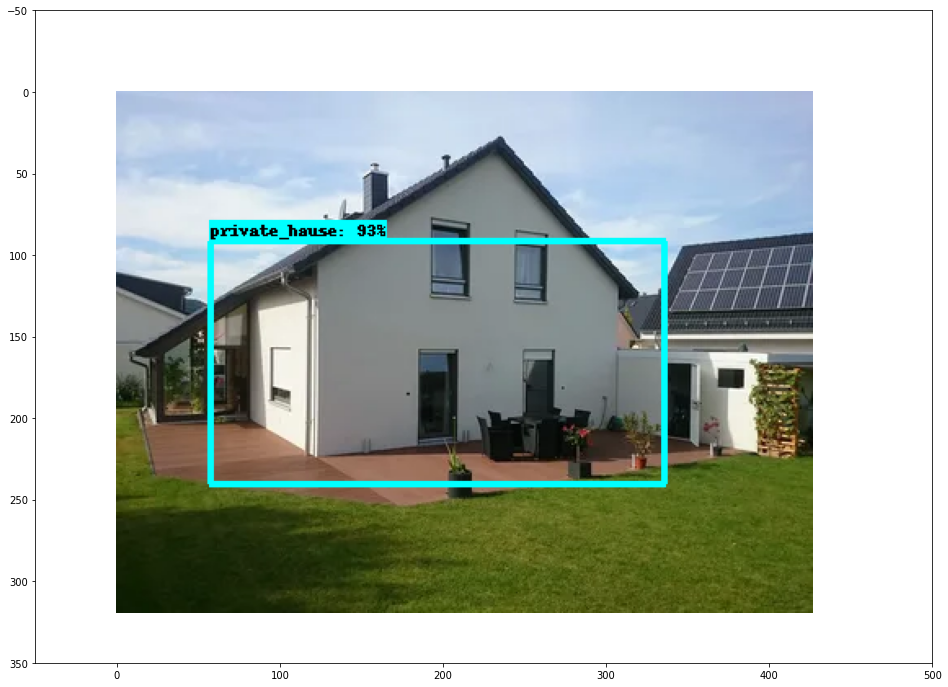

In [18]:
%matplotlib inline

PATH_TO_MODEL = "/content/training_demo/training/output_inference_graph_v1.pb/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/training_demo/annotations/label_map.pbtxt"

PATH_TO_IMAGE = "/content/training_demo/images/test/p2.jpg"
NUM_CLASSES = 2

# Load a model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Load labels
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

      image = Image.open(PATH_TO_IMAGE)
      
      # Convert image to numpy array
      (im_width, im_height) = image.size    
      image_np = np.array(image.getdata()).reshape((im_height, im_width,3)).astype(np.uint8)      
    
      image_np_expanded = np.expand_dims(image_np, axis=0)
      
      # Extract image tensor
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      
      # Extract detection boxes
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      
      # Extract detection scores
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      
      # Extract detection classes
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      
      # Extract number of detectionsd
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
     
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4,
          min_score_thresh = 0.5
          )
     
      IMAGE_SIZE = (18, 12)
      plt.figure(figsize=IMAGE_SIZE)
      plt.axis([-50,500,350,-50])
      plt.imshow(image_np)  

Протестируем работу детектора на фотографии небоскреба

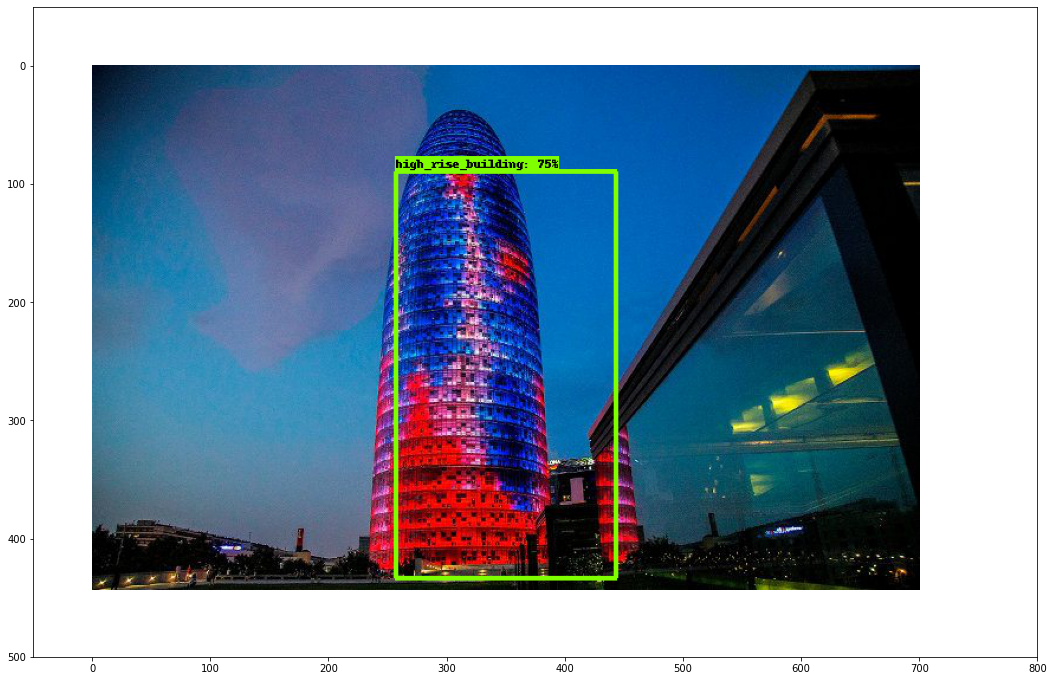

In [37]:
%matplotlib inline

PATH_TO_MODEL = "/content/training_demo/training/output_inference_graph_v1.pb/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/training_demo/annotations/label_map.pbtxt"

PATH_TO_IMAGE = "/content/pb8.jpg"

NUM_CLASSES = 2

# Load a model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Load labels
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

      image = Image.open(PATH_TO_IMAGE)
      
      # Convert image to numpy array
      (im_width, im_height) = image.size    
      image_np = np.array(image.getdata()).reshape((im_height, im_width,3)).astype(np.uint8)      
    
      image_np_expanded = np.expand_dims(image_np, axis=0)
      
      # Extract image tensor
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      
      # Extract detection boxes
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      
      # Extract detection scores
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      
      # Extract detection classes
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      
      # Extract number of detectionsd
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
     
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4,
          min_score_thresh = 0.5
          )
     
      IMAGE_SIZE = (18, 12)
      plt.figure(figsize=IMAGE_SIZE)
      plt.axis([-50,800,500,-50])
      plt.imshow(image_np)  

Скачаем папку training_demo с обученной моделью и набором картинок. Для этого сожмем папку training_demo и скачаем архив 

In [39]:
!zip -r /content/training_demo.zip /content/training_demo

  adding: content/training_demo/ (stored 0%)
  adding: content/training_demo/annotations/ (stored 0%)
  adding: content/training_demo/annotations/label_map.pbtxt (deflated 27%)
  adding: content/training_demo/annotations/test_labels.csv (deflated 73%)
  adding: content/training_demo/annotations/test.record (deflated 0%)
  adding: content/training_demo/annotations/train_labels.csv (deflated 76%)
  adding: content/training_demo/annotations/train.record (deflated 0%)
  adding: content/training_demo/training/ (stored 0%)
  adding: content/training_demo/training/pipeline.config (deflated 69%)
  adding: content/training_demo/training/model.ckpt-261.index (deflated 72%)
  adding: content/training_demo/training/model.ckpt-500.index (deflated 72%)
  adding: content/training_demo/training/graph.pbtxt (deflated 97%)
  adding: content/training_demo/training/checkpoint (deflated 66%)
  adding: content/training_demo/training/model.ckpt-0.meta (deflated 93%)
  adding: content/training_demo/training/m

In [40]:
files.download('/content/training_demo.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>